In [13]:
# Import Dependencies.
import numpy as np 
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torchvision import datasets,transforms, models
from sklearn.model_selection import train_test_split

In [14]:
# Read in csv files.
traindata=pd.read_csv('data/train.csv')
testdata = pd.read_csv('data/test.csv', dtype=np.float32)

traindata.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Normalize train data.
targets_numpy = train_data.label.values
features_numpy = train_data.loc[:, train_data.columns != "label"].values/255

In [16]:
# Divide data intro training and testing.
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
targets_numpy,
test_size = 0.2,
random_state = 42)

In [17]:
# Check data types before using Tensor. Data type usage documentation here(https://pytorch.org/docs/stable/tensors.html)
print('features_train data type: ' + str(features_train.dtype)) 
print('features_test data type: ' + str(features_test.dtype)) 
print('targets_train data type: ' + str(targets_train.dtype)) 
print('targets_test data type: ' + str(targets_test.dtype)) 

features_train data type: float64
features_test data type: float64
targets_train data type: int64
targets_test data type: int64


In [18]:
featuresTrain = torch.FloatTensor(features_train)
# int64 and long data types use torch.LongTensor
targetsTrain = torch.LongTensor(targets_train) 

# create feature and targets Tensor for test set.
featuresTest = torch.FloatTensor(features_test)
targetsTest = torch.LongTensor(targets_test)

In [19]:
print(type(featuresTest))
print(type(targetsTest))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [20]:
trainset = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
testset = torch.utils.data.TensorDataset(featuresTest,targetsTest)

In [21]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = False)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = False)

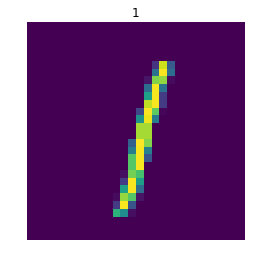

<Figure size 432x288 with 0 Axes>

In [22]:
# visualize one of the images in data set.
plt.imshow(features_numpy[15].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[15]))
plt.show()
# Save the figure.
plt.savefig('graph.png')


In [23]:
# PyTorch documentation for nn.Modules (https://pytorch.org/docs/stable/_modules/torch/nn/modules/module.html)
class classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(784, 256)
        self.fc2=nn.Linear(256,128)
        self.fc3=nn.Linear(128,10)
        self.dropout = nn.Dropout(p=0.2)
    def forward (self,x):
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=F.log_softmax(self.fc3(x),dim=1)
        return x

In [24]:
model=classifier()
# Negative log likelihood loss. Useful to train classification problems with C classes.
criterion=nn.NLLLoss()
# Optimizer holds the current state and updates the parameters based on computer gradients 
# Adam: A Method for Stochastic Optimization. Adam, an algorithm for first-order gradient-based optimization of stochastic objective functions, 
# based on adaptive estimates of lower-order moments. The method is straightforward to implement, is computationally efficient, has little memory 
#requirements,is invariant to diagonal rescaling of the gradients, and is well suited for problems that are large in terms of data and/or parameters.
optimizer=optim.Adam(model.parameters(),lr=0.004)

In [25]:
train_on_gpu=torch.cuda.is_available()
if train_on_gpu:
    model.cuda()

In [26]:
epochs = 5
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        if train_on_gpu:
            images,labels=images.cuda(),labels.cuda()
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation to save memory and computation.
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                if train_on_gpu:
                    images,labels=images.cuda(),labels.cuda()
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/5..  Training Loss: 0.313..  Test Loss: 0.174..  Test Accuracy: 0.945
Epoch: 2/5..  Training Loss: 0.160..  Test Loss: 0.159..  Test Accuracy: 0.952
Epoch: 3/5..  Training Loss: 0.129..  Test Loss: 0.155..  Test Accuracy: 0.955
Epoch: 4/5..  Training Loss: 0.113..  Test Loss: 0.125..  Test Accuracy: 0.966
Epoch: 5/5..  Training Loss: 0.101..  Test Loss: 0.124..  Test Accuracy: 0.966


In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'



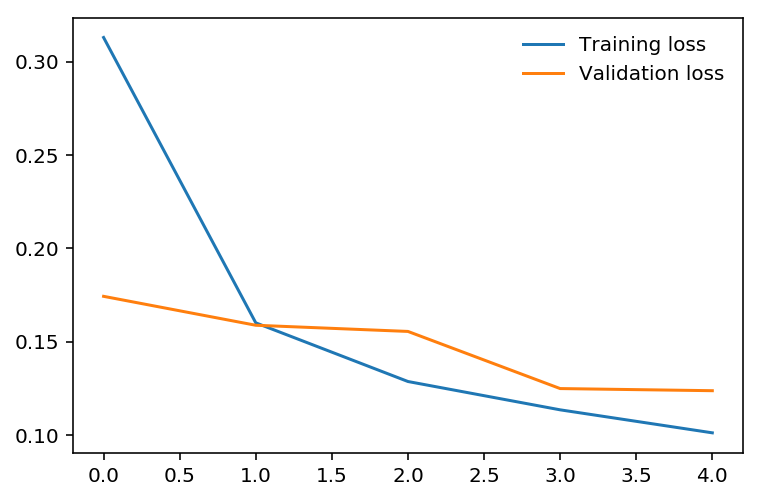

In [28]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [29]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [30]:
# Test trained model on test.csv and store the output.
testdata.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Normalize the test data.
test_features = testdata.loc[:].values/255 

In [32]:
testfeatures = torch.from_numpy(test_features)

In [33]:
# Check the data shape to ensure test data is being used.
print(testfeatures.shape)

torch.Size([28000, 784])


In [34]:
# Create a dummy label list to make a dataset.
testlabels = torch.ones_like(testfeatures) 

In [35]:
print(testlabels.shape)

torch.Size([28000, 784])


In [36]:
testset = torch.utils.data.TensorDataset(testfeatures, testlabels)

In [37]:
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = False)

In [38]:
# A loop for storing labels and image id's, print out any errors.
ImageId = []
Label = []
model.eval()
count = -1
for images, labels in (testloader):
    count += 1
    if train_on_gpu:
        images = images.cuda()
    log_ps = model(images)
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)
    i = 0
    for i in range(64):
        # our dataset is not exactly divisible by 64 so it will go out of bound at some point           
        try:
            # Store label.
            Label.append(top_class[i].item()) 
            # Store ImageId
            ImageId.append(count*64+i+1) 
        except Exception:
            print(i)

32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


In [39]:
# Checking our first 50 labels Labels should contain number from 0 to 9.
print((Label[:50]))

[2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 1, 5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7, 8, 2, 6, 7]


In [40]:
# Check first 50 ImageId. should be an ascending list from 1 all the way to 50.
print(ImageId[:50])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


In [41]:
submission = {
    'ImageId' : ImageId,
    'Label' : Label
}

In [48]:
df = pd.DataFrame(submission)
df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [49]:
# Save submission to a csv file
df.to_csv('data/submission.csv', index=False)

In [51]:
# Double check to make sure the right data has been saved.
dataa=pd.read_csv('data/submission.csv')
dataa.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
